# generate videos of spiral tips with streams predictive of extinction dynamics
Tim Tyree<br>
3.22.2022

In [3]:
from lib.my_initialization import *
from lib.model.minimal_model_cuda import *
from lib import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [4]:
import shutil
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

In [6]:
# 993MiB /  7982MiB
# 7982/993=8.03...>8
npartitions_gpu=1
npartitions=os.cpu_count()-1
assert npartitions>0

# define module

In [107]:
#input: gpu output in cpu memory
#ouput:  dict_out,img,dimg_dt
def measure_system_luo_rudy(img,dimg_dt,V_threshold,**kwargs):
    """
    kwargs may not be conected to anything
    returns dict_out,img,dimg_dt
    
    Example Usage:
dict_out=measure_system_luo_rudy(img,dimg_dt,V_threshold)
    """
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t=9999.,img=img,dimgdt=dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    return dict_out

In [129]:
#DONE: dev viewer routine_to_png
#input: dict_out,img,dimg_dt,save_dir
#output: save_dir
def routine_to_png_streaming_tips(task):
    dict_out,img,dimg_dt,save_dir=task
    #define constant parameters
    # fontsize=22
    # xy=(0.75, 0.9)
    inch=6
    fontsize=30
    xy=(0.67, 0.9)
    #define constant coordinate mesh for stream generation
    width=200.#pixel
    height=200.#pixel
    DX=0.025#cm/pixel
    #generate plot
    #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
    fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
    ax=fig.add_subplot()
    #plot the mesh
    X_=np.arange(width)
    Y_=np.arange(height)
    X,Y = np.meshgrid(X_, Y_)
    ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')
    #ax.pcolormesh(X, Y, img, ,vmin=-80,vmax=40,cmap='bone', shading='auto')

    #compute vector field
    ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
    vx=-ddVdtdx #looks good
    vy=-ddVdtdy
    # vx=ddVdtdx #looks meh
    # vy=ddVdtdy

    #compute the streamplot
    strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                         density=0.5)#density=2)#way too much 
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        start_points = list(zip(x_values,y_values))
        strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                              color="crimson", #"orange", 
                              linewidth=2,
        #                       integration_direction='forward')
        #                       integration_direction='backward')
                              integration_direction='both')
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

        #record the stream for later analysis
        stream_array=strmS.lines.properties()['segments']
        dict_out['stream_array']=stream_array
    
    #complicated formatting
    #add text of label
#     label=f"Vth={V_threshold}"
    label=r"$-\nabla \partial_tV$"#+'\n'
    ax.annotate(label, xy=xy, 
                xycoords='axes fraction',
    #             xycoords='data',
    #             xycoords='polar',
                fontsize=fontsize,alpha=0.8)
    #(alternative method with small font...)add text box with label
    # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
    # ax.add_artist(anchored_text)
    # anchored_text.set_alpha(0.1)
    # annotating=False
    # if annotating:
    #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
    #     message_string=f"  num. = {n_tips}"
    #     ax.text(.0,.95,time_step_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    #     ax.text(.0,.9,message_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    ax.axis("off")
    plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return save_dir

In [109]:
1

1

# test my one_step method for the Luo-Rudy model

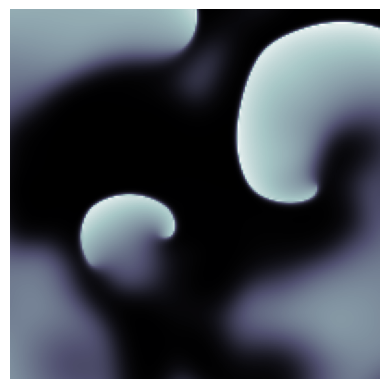

In [116]:
#DONE: load initial condition from the Luo-Rudy model
# ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.11.npz"
t=0

txt_lr=load_buffer(ic_fn)
txt_lr.shape


fontsize=16
#plot the field
plt.imshow(txt_lr[...,0],cmap='bone')
plt.axis('off')
plt.show()

In [115]:
get_one_step_explicit_synchronous_splitting_w_Istim

<function lib.controller.controller_LR.get_one_step_explicit_synchronous_splitting_w_Istim(nb_dir, dt=0.01, width=200, height=200, ds=5.0, diffCoef=0.001, Cm=1.0, **kwargs)>

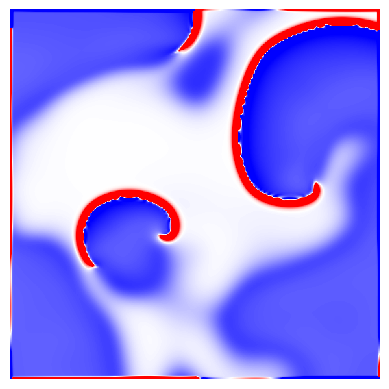

In [117]:
ds=5.
frameno=1
# txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_lr)
width,height=txt_lr.shape[:2]
V_threshold=-50
# dt=0.1 #supports really long termination time...
dt=0.025
diffCoef=0.0005#0.001#
Cm=1.0
# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=diffCoef,Cm=Cm)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)


_,arr39,one_step_lr=get_one_step_explicit_synchronous_splitting_w_Istim(nb_dir,dt=dt,width=200,height=200,ds=5.,diffCoef=diffCoef,Cm=1.)#,**kwargs)

zeros_txt=np.zeros(shape=(width,height))
txt_Istim=zeros_txt.copy()
one_step_lr(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,txt_Istim)
#TODO: compute the flow map for the Luo-Rudy model
# one_step?
vmax=3
plt.imshow(dVcdt[...,0],cmap='bwr',vmin=-vmax,vmax=vmax)
plt.axis('off')
plt.show()

In [118]:
#input: ic_fn (Luo-Rudy)
#output: txt_init at time t=100 ms
printing=True
txt_lr=load_buffer(ic_fn)
txt=txt_lr.copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
# print(f"{txt.shape=}")
one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,nb_dir,V_threshold=V_threshold,jump_threshold=40,diffCoef=diffCoef)#,**kwargs)
comp_dict_topo_full_color=comp_dict_tips
#reidentify the tips to be tracked
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_tips=comp_dict_tips(img, dimgdt, t, txt)

t=0
tf=100.#ms
DT=0.025#ms per one_step call
nsteps=int(np.around(tf/DT))
print(f"forward integrating to  tf={tf:.3f} ms...")
for step in range(nsteps):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    #update progressbar
    if printing:
        printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete', length = 50)
#         printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds)', length = 50)
txt_init=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

forward integrating to  tf=100.000 ms...


In [119]:
txt=txt_init.copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

#measure system
img=inVc[...,0].astype(np.float32)
dimgdt=dVcdt[...,0].astype(np.float32)
dict_tips=comp_dict_tips(img, dimgdt, t, txt)
dict_tips['n']=len(dict_tips['pid'])

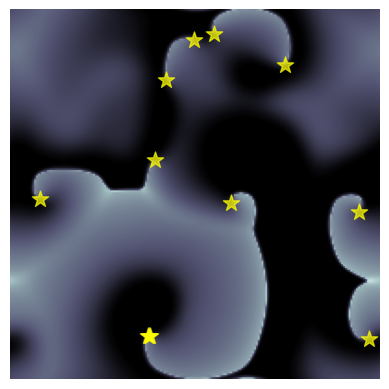

In [125]:
#DONE: visualize spiral tips and verify that they look reasonable
# vmax=3
# plt.imshow(dimgdt,cmap='bwr',vmin=-vmax,vmax=vmax)
plt.imshow(img,cmap='bone',vmin=-80,vmax=40)#,shading='gouraud')
plt.scatter(dict_tips['x'],dict_tips['y'],marker='*',s=150,alpha=0.7,color='yellow')
plt.axis('off')
plt.show()

In [121]:
init_methods?

## TODO(later): implement one_step method for Luo-Rudy model on the gpu


In [30]:
#TODO(later): implement one_step method for Luo-Rudy model on the gpu
# # from lib.model.minimal_model_cuda import *
# #the following might be needed for the kernel_autotuner.
# # drv.init()

# #define how resources are used
# width  = 200
# height = 200
# block_size_x=10
# block_size_y=10
# threads = (block_size_x,block_size_y,1)
# grid = (int(width/block_size_x, int(height/block_size_y), 1)
# block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

# #set spatial discretization
# DX=0.025 #cm
# # DY=0.025
# DT=0.025 #ms

# #initialize PyCuda and get compute capability needed for compilation
# context = drv.Device(0).make_context()
# devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
# cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

# #load parameters for parameter set 8 for the Fenton-Karma Model
# kwargs = read_parameters_from_json('lib/model/param_set_8.json')
# kwargs['width']=width
# kwargs['height']=height
# kwargs['DX']=DX
# # kwargs['DT']=DT
# # kwargs['DY']=DY

# #define the initial conditions
# Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

# u_initial = Vin.astype(np.float64)
# #initialize auxiliary textures to zero
# v_initial = np.zeros_like(u_initial)
# w_initial = np.zeros_like(u_initial)

# #don't allocate memory many times for the same task!
# #allocate GPU memory for voltage scalar field
# u_old = drv.mem_alloc(u_initial.nbytes)
# u_new = drv.mem_alloc(u_initial.nbytes)

# #allocate GPU memory for v and w auxiliary fields
# v_old = drv.mem_alloc(v_initial.nbytes)
# v_new = drv.mem_alloc(v_initial.nbytes)
# w_old = drv.mem_alloc(w_initial.nbytes)
# w_new = drv.mem_alloc(w_initial.nbytes)

# # explicit time integration up to 5 seconds in steps of size 0.025 ms
# kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
# iterations = 10**5

# #setup thread block dimensions and compile the kernel
# mod = SourceModule(block_size_string+kernel_string)
# time_step_kernel = mod.get_function("time_step_kernel")

# #create events for measuring performance
# start = drv.Event()
# end = drv.Event()

# #move the data to the GPU
# drv.memcpy_htod(u_old, u_initial)
# drv.memcpy_htod(u_new, u_initial)
# drv.memcpy_htod(v_old, v_initial)
# drv.memcpy_htod(v_new, v_initial)
# drv.memcpy_htod(w_old, w_initial)
# drv.memcpy_htod(w_new, w_initial)

# #call the GPU kernel 2*iterations times and measure performance
# context.synchronize()
# start.record()
# for i in range(iterations):
#     time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
#     time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
# end.record()
# context.synchronize()
# runtime = end.time_since(start)
# print(f"{iterations*2} time steps took {runtime:.0f} ms.")

# #copy the result from the GPU to Python for plotting
# gpu_result_u = np.zeros_like(u_initial)
# drv.memcpy_dtoh(gpu_result_u, u_old)
# gpu_result_v = np.zeros_like(v_initial)
# drv.memcpy_dtoh(gpu_result_v, v_old)
# gpu_result_w = np.zeros_like(w_initial)
# drv.memcpy_dtoh(gpu_result_w, w_old)

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
# ax1.imshow(u_initial)
# ax1.set_title("Initial Conditions\n$u_0$")
# ax2.imshow(gpu_result_u)
# ax2.set_title("Final Result From GPU\n$u$")

# ax3.imshow(v_initial)
# ax3.set_title("$v_0$")
# ax4.imshow(gpu_result_v)
# ax4.set_title("$v$")

# ax5.imshow(w_initial)
# ax5.set_title("$w_0$")
# ax6.imshow(gpu_result_w)
# ax6.set_title("$w$")
# plt.show()
# print_dict(kwargs)

## print the kernel_string for the one_step method for the Fenton-Karma model

In [362]:
print(kernel_string)


// primary model parameters
#define width  200
#define height 200
#define h      0.025
#define C_m    1.0
#define tau_pv 13.03
#define tau_v1 1250.0
#define tau_v2 19.6
#define tau_pw 800.0
#define tau_mw 40.0
#define tau_d  0.45
#define tau_0  12.5
#define tau_r  33.25
#define tau_si 29.0
#define K      10.0
#define V_sic  0.85
#define V_c    0.13
#define V_v    0.04

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef 0.80000000

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {
    if (q >= wid) {
        q = 0;
    }
    if (q < 0) {
        q = wid-1;
    }
    return q;
}

// heaviside step function
__device__ double step(double thresh, double x)
{
    return x >= thresh;
}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
 

# dev

In [114]:
from lib.viewer.viewer_cluster import *

In [112]:
# one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [122]:
# #default for luo-rudy
# # diffCoef=0.0005
# diffCoef=0.001

DT=dt
DT

0.025

In [111]:
# num_steps=22
# txt.astype(np.float64)
# txt_Istim=np.zeros_like(txt)
# forward_integrate_kernel=get_forward_integrate_kernel(nb_dir,dt,width,height,ds,stream,diffCoef=0.001,Cm=1.)
# forward_integrate_kernel(txt,txt_Istim, num_steps)

CPUDispatcher(<function get_one_step_explicit_synchronous_splitting.<locals>.one_step_explicit_synchronous_splitting at 0x7f9ce1bf7200>)

In [131]:
# load an initial conditions and integrate forward 100ms
# NOTES on runtime with the Luo-Rudy model: 
#simulating 1 termination event took 45 minutes
#1 movie generation took 1 hour total including simulation time
printing=True

ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/'
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'
ic_fn_lst=["ic008.11.npz"]

# #make a list of a bunch of initial conditions from the LR model
# ic_fn_lst=["ic002.31.npz",  "ic004.11.npz",  "ic005.33.npz",  "ic009.12.npz",  "ic011.33.npz",  "ic015.31.npz",  "ic017.23.npz",  "ic019.21.npz",
# "ic002.32.npz",  "ic004.12.npz",  "ic006.11.npz",  "ic009.31.npz",  "ic012.11.npz",  "ic015.32.npz",  "ic017.31.npz",  "ic019.23.npz"]

for ic_fn in ic_fn_lst:
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")

    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)

    #define the initial conditions
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    width_,height_=txt.shape[:2]
    assert (width_==width)
    assert (height_==height)
    
    t=0
    tf=100.#ms
#     DT=0.025#ms per one_step call
    nsteps=int(np.around(tf/DT))
    #print(f"forward integrating to  tf={tf:.3f} ms...")
    # iterations = 67
    if printing:
        print(f"forward integrating to tf={tf:.3f} ms (iterations={nsteps})...")
    for step in range(nsteps):
        one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
        #update progressbar
        if printing:
            printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete', length = 50)
    #stack txt
    txt_init=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt) #may not be used

    #record final time as new time
    t=tf

    compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

    img=inVc[...,0].astype(np.float32)
    dimg_dt=dVcdt[...,0].astype(np.float32)
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
    print_dict(dict_out)
    if dict_out['n']>0:
        #generate results for this set of initial conditions
        save_every=67 #leads to exactly a 10/1.05 ~10X slowdown
        save_every=22 #~30X slowdown
        fps=60 #i checked the ffmpeg routine
        # video_duration=30 #seconds
        video_duration=15 #seconds
        pause_after_termination_duration=1. #second
        accumulated_time_after_termination=0.
        #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time

        #time evolve txt on gpu saving to cpu once every 67 time steps
        iterations=save_every
        number_frames=np.around(video_duration*fps)
        nsteps=number_frames
        t_final=tf+DT*iterations*nsteps
        if printing:
            print(f"system initialized at time: {t} ms")
            print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
            print(f"forward integrating to tf={t_final/1e3} seconds...")
        dict_out_lst=[]
        img_lst=[]
        dimg_dt_lst=[]
        start = time.time()
        for step in range(nsteps):
            for i in range(iterations):
                one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
            
            #measure
            img=inVc[...,0].astype(np.float32)
            dimg_dt=dVcdt[...,0].astype(np.float32)
            dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
            #dict_out=measure_system_luo_rudy(img,dimg_dt,V_threshold)
            #update time
            t=(tf+DT*step*iterations)*0.001 #seconds
            dict_out['t']=t
            #record
            dict_out_lst.append(dict_out)
            img_lst.append(img)
            dimg_dt_lst.append(dimg_dt)
            #update progressbar
            if printing:
                n=dict_out['n']
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds, num. tips:{n})', length = 50)

            if dict_out['n']==0:
                #the number of tips is zero
                accumulated_time_after_termination+=DT*iterations
                if accumulated_time_after_termination>pause_after_termination_duration:
                    # break the inner loop
                    break
            else:
                # continue if the inner loop wasn't broken
                continue
            # inner loop was broken, break the outer
            break

        runtime = time.time() - start
        if printing:
            print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
        # beep(1)

        #generate movie of data currently in virtual memory
        dump_cache=True
        save_folder = os.path.join(nb_dir,f'Figures/mov')
        #dump save_folder if it already exists
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        assert (os.path.exists(save_folder))
        if dump_cache:
            shutil.rmtree(save_folder)
            print(f"dumped cache at {save_folder}")
            os.mkdir(save_folder)

        task_lst=[]
        for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
            save_fn=f"img{frameno:07d}.png"
            save_dir=os.path.join(save_folder,save_fn)
            task=dict_out,img,dimg_dt,save_dir
            task_lst.append(task)
        task_lst.pop(-1)
        if printing:
            print(f"added {len(task_lst)} tasks to task_lst")

        testing=False
        if testing:
            task_index=-100
            task = task_lst[task_index]
            routine_to_png_streaming_tips(task)
            if printing:
                print(task[-1])

        if printing:
            print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
            print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
            print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
            #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time


        #this took ?? hours for 16 trials
        start=time.time()
        if printing:
            print(f"generating {len(task_lst)} .png files over {npartitions} cores...")
        retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
        if printing:
            print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
        #beep(2)
        #NOTE: the following was much slower
        # #concatenate the folder of png files to a video
        # os.chdir(f"{nb_dir}/../vid/src")
        # !./concat_folder_png.sh
        # if printing:
        #     print(f"V_threshold={V_threshold}")
        # beep(3)
        #concatenate the folder of png files to a video
        os.chdir(f"{nb_dir}/../vid/src")
        os.system("./concat_folder_png.sh");
        #copy output movie to a file uniquely named for this recording session
        # fn=ic_fn
        fn=os.path.basename(ic_dir)
        save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
        os.chdir(f"{nb_dir}/../vid/mov")
        folder=f'streaming_tips_luo_rudy_diffCoef_{diffCoef}'
        if not os.path.exists(folder):
            os.mkdir(folder)
        os.system(f"cp out.mov {os.path.join(folder,save_mov_fn)}")
        # beep(3)
        if printing:
            print(f"{os.path.abspath(save_mov_fn)}")
        #save dict_out_lst to .pkl in new folder in Data/
        save_pkl_folder=os.path.join(ic_folder,'..',folder)
        if not os.path.exists(save_pkl_folder):
            os.mkdir(save_pkl_folder)
        save_pkl_fn=fn.replace('.npz','.pkl')
        save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
        save_to_pkl(save_pkl_dir,dict_out_lst)
        print(f"save_pkl_dir='{save_pkl_dir}'")

ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic008.11.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
t=100.0s: |██████████████████████████████████████████████████| 100.0% Complete
n=12
x=[12.933456204642479, 16.096734114862983, 29.785793914976473, 37.77732336457498, 81.2370735576494, 101.95772852355972, 104.26753822919305, 109.16204144668171, 176.1894031506381, 176.11666002541855, 176.14280946414473, 177.90511137348184]
y=[109.81114846173256, 99.32826860302578, 148.0512683312948, 84.13074416769331, 78.21500758892867, 15.708465830287905, 119.34104222955915, 188.10662752491825, 73.91668790282883, 74.5995942693882, 75.12862606897222, 193.57959125367657]
grad_ux=[-0.9033888374961543, -0.5141927710825204, 1.463444006929567, -0.7048879630508944, 2.308963977143075, 1.1597643662876078, 0.3589827084066967, 0.29527750787458784, 1.0719916962064497, 1.4174686166258423, 1.6010986808235232, 1.4442550614052958]
grad_uy=[1.20932876

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

/home/timothytyree/Documents/GitHub/care/vid/mov/ic008.11_streaming_tips.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../streaming_tips_luo_rudy_diffCoef_0.0005/ic008.11.pkl'


frame= 2399 fps=244 q=-1.0 Lsize=    4764kB time=00:00:39.93 bitrate= 977.4kbits/s dup=1 drop=0 speed=4.06x    
video:4730kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.694145%
[libx264 @ 0x55b1ded06c80] frame I:10    Avg QP:29.29  size: 15153
[libx264 @ 0x55b1ded06c80] frame P:708   Avg QP:33.45  size:  4641
[libx264 @ 0x55b1ded06c80] frame B:1681  Avg QP:29.50  size:   836
[libx264 @ 0x55b1ded06c80] consecutive B-frames:  4.2%  5.5%  5.1% 85.2%
[libx264 @ 0x55b1ded06c80] mb I  I16..4: 27.6% 59.5% 12.9%
[libx264 @ 0x55b1ded06c80] mb P  I16..4:  2.1%  3.4%  1.4%  P16..4: 19.1%  4.3%  1.3%  0.0%  0.0%    skip:68.3%
[libx264 @ 0x55b1ded06c80] mb B  I16..4:  0.2%  0.2%  0.1%  B16..8: 12.3%  0.8%  0.1%  direct: 0.1%  skip:86.3%  L0:52.3% L1:47.0% BI: 0.7%
[libx264 @ 0x55b1ded06c80] 8x8 transform intra:50.2% inter:63.3%
[libx264 @ 0x55b1ded06c80] coded y,uvDC,uvAC intra: 22.9% 24.1% 3.3% inter: 1.1% 0.7% 0.3%
[libx264 @ 0x55b1ded06c80] i16 v,h,dc,p: 33% 19

In [ ]:
print(f"save_pkl_dir='{save_pkl_dir}'")
assert os.path.exists(save_pkl_dir)

In [ ]:
#this took ?? hours for 16 trials

In [ ]:
# # - DONE: add $-\nabla\partial_t V_m$ as an inset text box with a white background, plt.axis('off')
# # - DONE: make a function that saves a matplotlib plot to .png as a video frame, as before
# # - DONE: determine a reasonable frame rate
# # - DONE: forloop over this, generating a folder of .png frames
# # - DONE: concatenate folder of  .png frames using ffmpeg, as before
# # - DONE: if the movie looks good and is reasonably small in memory, consider sharing it... or share it during our recurring meeting tomorrow at 2pm with WJ and PM
# DONE: repeat for (gpu_accelerated?) one_step method from the Luo-Rudy model
# DONE: overnight, let a folder of comparable small videos be generated for either/both of the full models